### Loading up required libraries and configurations

In [324]:
import quandl
import pandas_datareader.data as web
import datetime
import pandas as pd
import sklearn
import numpy as np
from collections import defaultdict
from IPython.display import display
import scipy as sp
from operator import methodcaller
import time

#set reload
%reload_ext autoreload
%autoreload 2

# evaluate usage
pd.options.mode.chained_assignment = None  # default='warn'

In [184]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
%matplotlib inline

In [3]:
 quandl.ApiConfig.api_key = "1513txcURR4fYyP5VDU3"

In [4]:
ibx50 = ['ABEV3','BBAS3','BBDC3','BBDC4','BBSE3','BRFS3','BRKM5','BRML3','BVMF3',
         'CCRO3','CIEL3','CMIG4','CPFE3','CSAN3','CSNA3','CTIP3','EGIE3','EMBR3',
         'ENBR3','EQTL3','ESTC3','FIBR3','GGBR4','GOAU4','HYPE3','ITSA4','ITUB4',
         'JBSS3','KLBN1','KROT3','LAME4','LREN3','MRVE3','MULT3','NATU3','PCAR4',
         'PETR3','PETR4','QUAL3','RADL3','RUMO3','SBSP3','SMLE3','SUZB5','UGPA3',
         'USIM5','VALE3','VALE5','VIVT4','WEGE3']

### Loading data

Given a simple trading strategy: buy stock X, hold for N days, sell it once it reaches V% valuation.
We will the optimal parameters for N (span, or number of days you hold the asset in the portfolio) and V (expected valuation before sell). For simplification, the stop loss will be optimized by the trading agent, and not used in the classification problem.

In [325]:
# prep data
%aimport data_transform
%aimport simulator
start_date='2002-1-1'
end_date='2014-12-31'
market_df = data_transform.download_market_data(start_date=start_date, end_date=end_date)

In [326]:
market_df.columns

Index(['Bovespa total volume', 'BM&F Gold gramme',
       'Foreign exchange operations balance', 'Exchange Rate USD Sell',
       'Dow Jones index', 'Bovespa index', 'Nasdaq index', 'Selic',
       'International Reserves'],
      dtype='object')

In [312]:
# define a group of stocks in which the algorithm will be tested
stocks= ['ABEV3', 'BBDC4', 'ITUB4', 'PETR4', 'VALE5'] # represents around 25% of IBOV

### Market Data

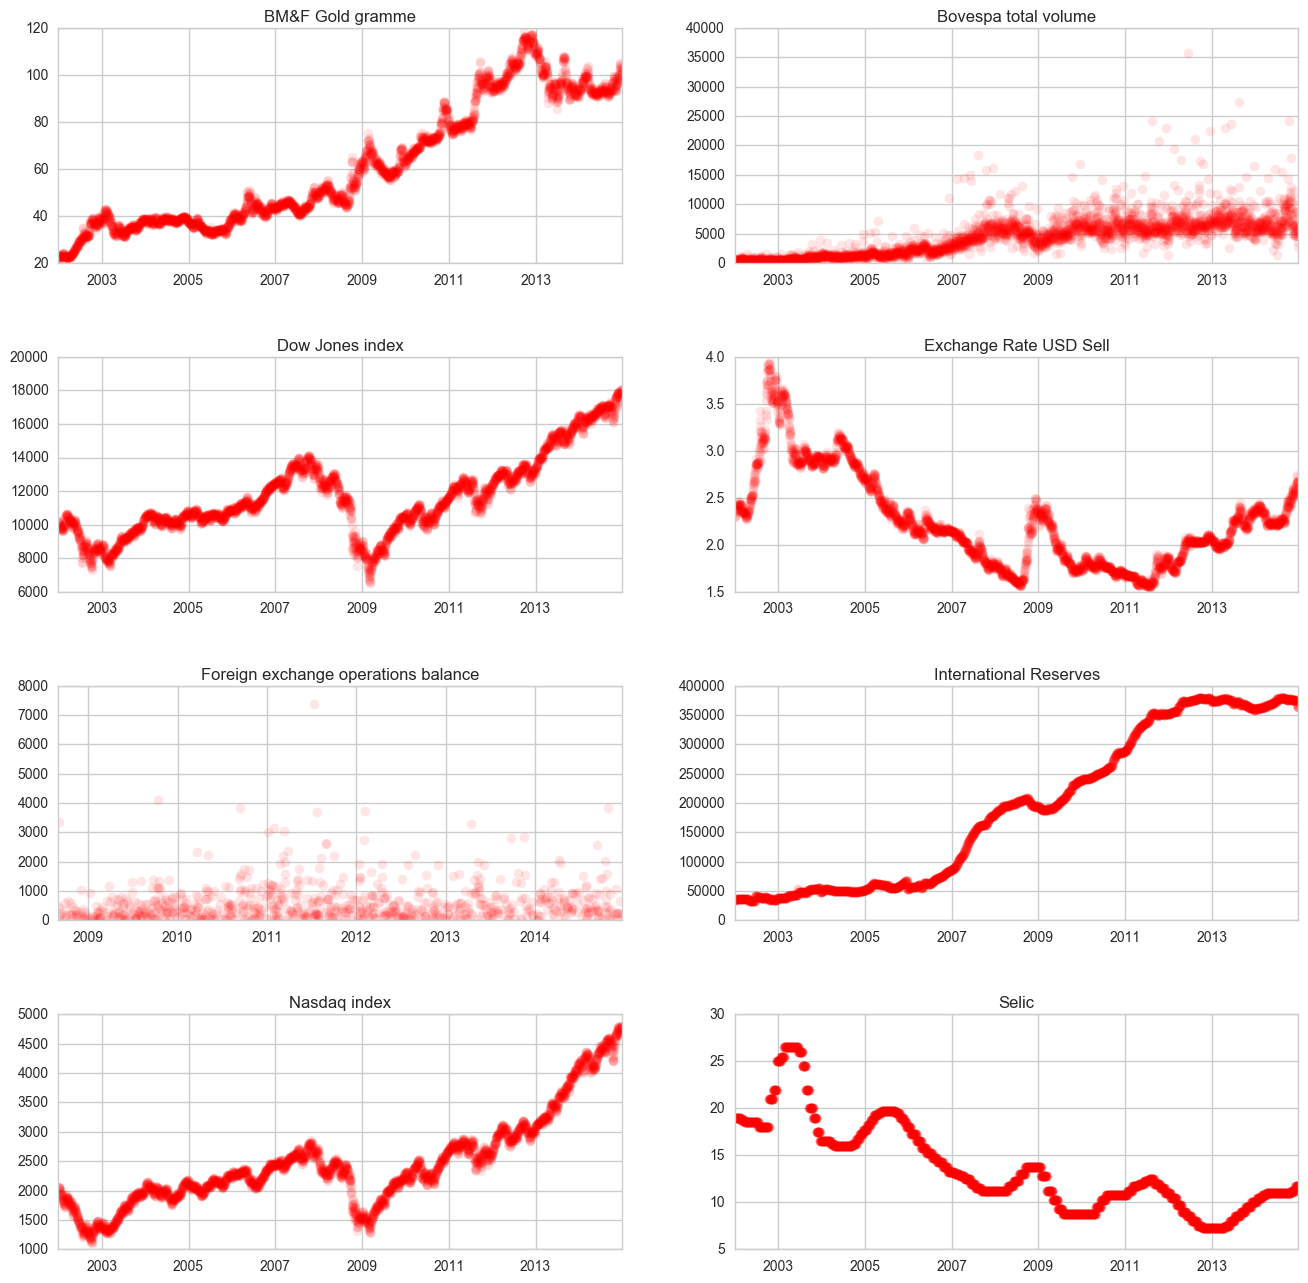

In [327]:
plt.figure(figsize=(16,20))
grid = gs.GridSpec(5,2)
grid.update(wspace=.2, hspace=.4)
sns.set_style("whitegrid")
for i, col in enumerate(sorted(market_df.columns - ['Bovespa index'])):
    ax = plt.subplot(grid[i])
    ax.plot(market_df[market_df[col]>0][col], 'ro', alpha=.1)
    plt.title(col)

As expected, those are time series dataset with swings up and down according to market behavior. The dots on a straight line shows no outliers in most variables.

The two features which don't behave like a time series are Foreign Exchange Operations balance and Bovespa total. Foreign Exchange Operations Balance swing wildly. Total Volume, while it increases with time, it does not have a clear trend. Let's look at their distribution closer

12.862078999517855

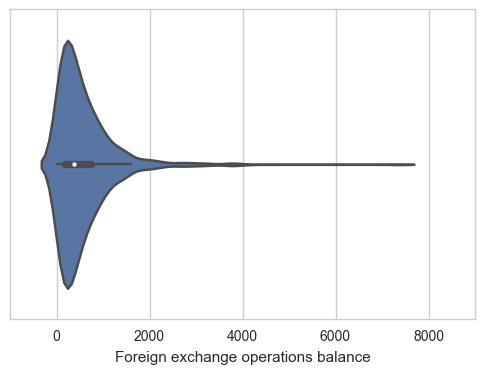

In [103]:
col = 'Foreign exchange operations balance'
sns.violinplot(market_df[market_df[col]>0][col])
market_df[market_df[col]>0][col].max() / market_df[market_df[col]>0][col].mean()

8.2055385720713776

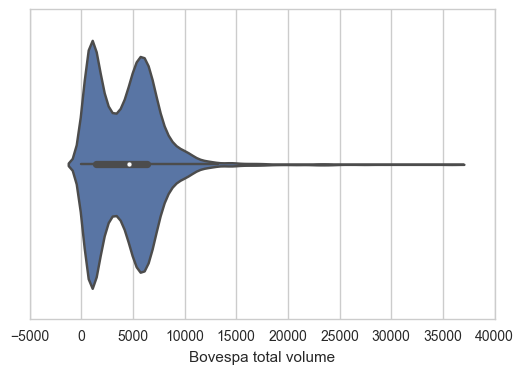

In [104]:
col = 'Bovespa total volume'
sns.violinplot(market_df[market_df[col]>0][col])
market_df[market_df[col]>0][col].max() / market_df[market_df[col]>0][col].mean()

These two variables seems more sensitive to outliers. The tail extends to 10x higher than the mean.

### Data on asset

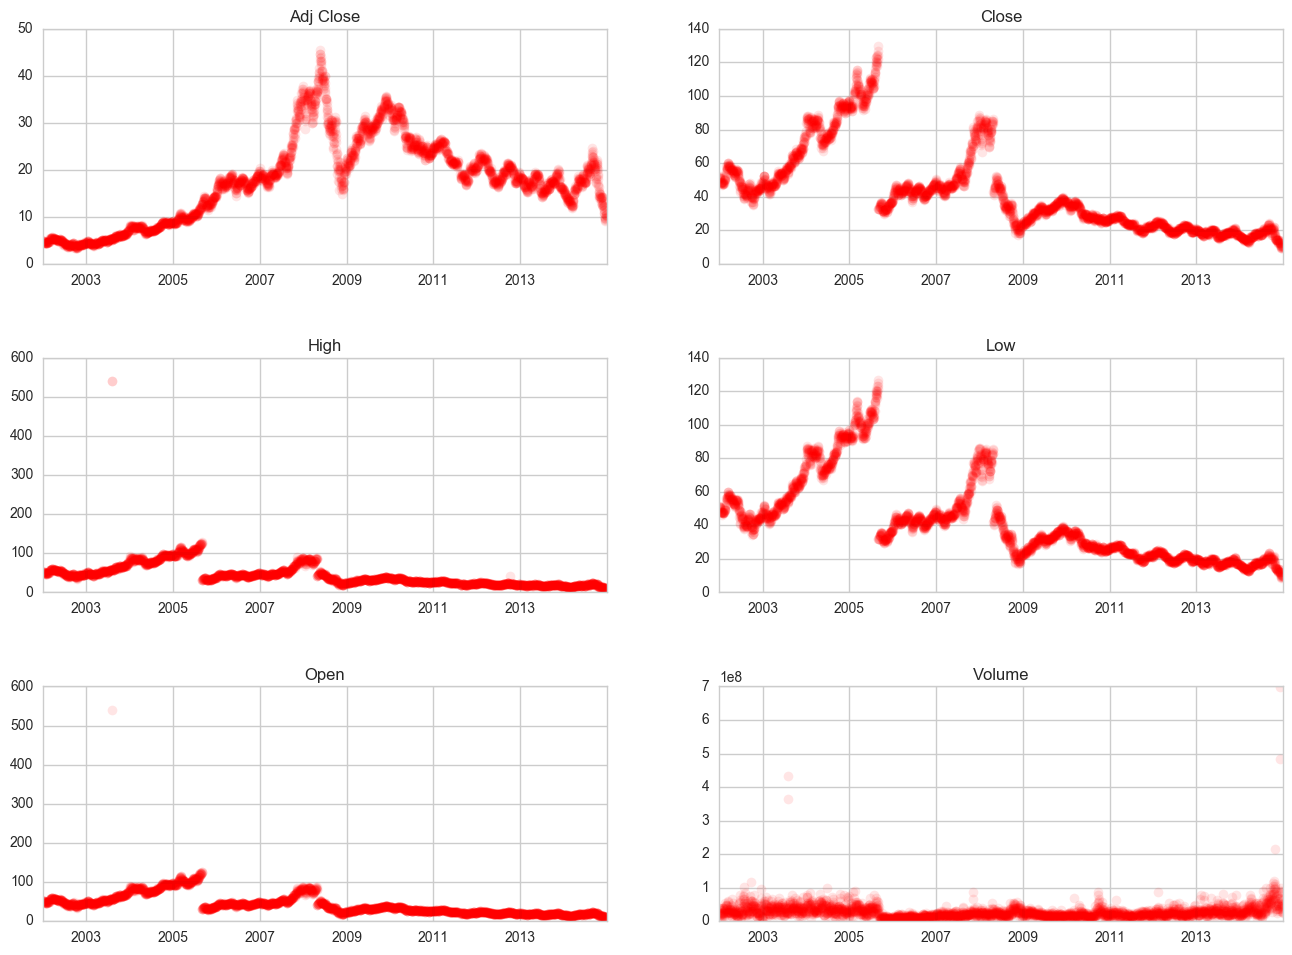

In [124]:
plt.figure(figsize=(16,20))
grid = gs.GridSpec(5,2)
grid.update(wspace=.2, hspace=.4)
sns.set_style("whitegrid")
for i, col in enumerate(sorted(stock_df.columns)):
    ax = plt.subplot(grid[i])
    ax.plot(stock_df[stock_df[col]>0][col], 'ro', alpha=.1)
    plt.title(col)

Open, High, Low and Close break every time the stock splits - Adj Close is the actual reflection of price. Itis interesting to see one outlier in open and high for this stock, around 2003, I wonder what that event represented. I've googled it and haven't found an answer. But apart from that, no surprises here, and it represents only one assets of many to be analyzed.

24.841148662190378

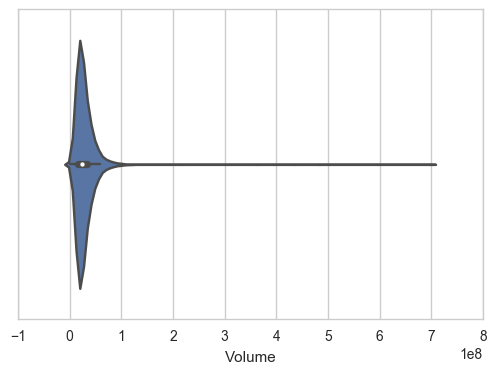

In [126]:
col = 'Volume'
sns.violinplot(stock_df[stock_df[col]>0][col])
stock_df[stock_df[col]>0][col].max() / stock_df[stock_df[col]>0][col].mean()

It is clear here as well volume has a lot of outliers and is not a time series feature.

### Correlation

Let's add to the dataset data from one stock and visually check their correlation with the features mentioned above>

In [169]:
symbol = 'PETR4'
stock_df = data_transform.get_stock_data(symbol, start_date, end_date)
df = data_transform.merge_datasets(stock_df['Adj Close'], market_df)

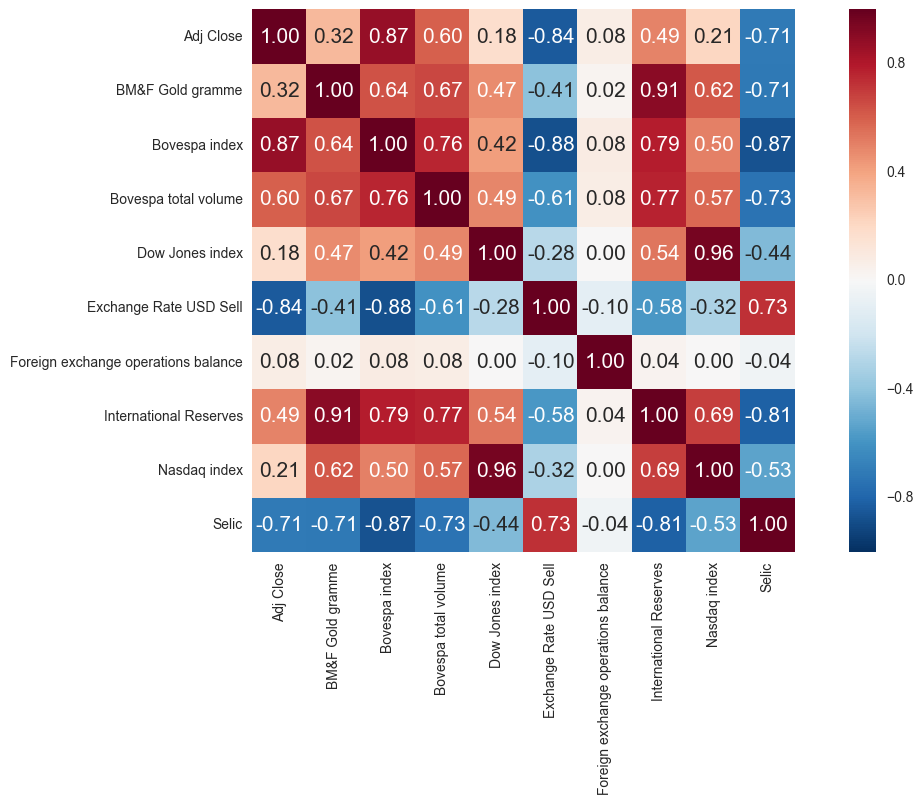

In [170]:
cols = sorted(df.columns)
cm = np.corrcoef(df[cols].values.T)
plt.figure(figsize=(14, 7))
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws = {'size': 15},
                yticklabels=cols,
                xticklabels=cols)

Correlation of PETR4 asset is high with 3 variables: Selic (basic interest rate), Bovespa index (expected, as PETR4 is a major component of Ibovespa), and USD Exchange Rate (also a known fact - both the main product of PETR4, petrol, and its debts, are tied to dollar currency).

It is important to emphasize here this is one asset - eventually we will be looking at over a thousand. Correlation and features will change according to the asset being analyzed, which is why this analysis, although useful, should not be hand made.

### Trend Analysis

In [258]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

In [270]:
# let's get the full dataset, with transformation
base, span, profit= 60,10,.09
# 1. get stock data
df = data_transform.get_stock_data(symbol=symbol, start_date=start_date, end_date=end_date)
# 2. add market data
df = data_transform.merge_datasets(df, market_df)
# 3. calculate stock indicators
df = data_transform.get_tech_indicators(df)
# 4. create features
df = data_transform.create_features(df, base=base)
# 5. create labels
df = data_transform.create_labels(df, span=span, profit=profit)
# 6. split features and labels
X,  y = data_transform.split_features_labels(df)
print(np.bincount(y))
# 7. scale
scaler = StandardScaler()
X = scaler.fit_transform(X)


[2661  503]


Let's understand feature relevances through different lenses:

In [271]:
# decision tree
features = [x for x in df.columns if x != "Label"]
f_selector = SelectPercentile(score_func=f_classif, percentile=10)
f_selector.fit(X, y)

SelectPercentile(percentile=10,
         score_func=<function f_classif at 0x117b66950>)

In [272]:
Xs = f_selector.transform(X)

In [273]:
sorted(zip(features, f_selector.scores_, f_selector.pvalues_), key=lambda x: -x[1])

[('Exchange Rate USD Sell-41', 180.40398891430337, 4.8526802886919875e-40),
 ('Exchange Rate USD Sell-38', 179.68865221889348, 6.8195186841883156e-40),
 ('Exchange Rate USD Sell-42', 179.3948328178044, 7.842600883294779e-40),
 ('Exchange Rate USD Sell-39', 179.28813637847816, 8.2509936325308728e-40),
 ('Exchange Rate USD Sell-40', 178.77604077209494, 1.0527584393960815e-39),
 ('Exchange Rate USD Sell-37', 177.59086518100275, 1.8505849599581912e-39),
 ('Exchange Rate USD Sell-43', 172.91454153993834, 1.7173566809741859e-38),
 ('Exchange Rate USD Sell-36', 170.23610302049039, 6.1619481883353512e-38),
 ('Exchange Rate USD Sell-34', 169.83978671223562, 7.4449167792990342e-38),
 ('Exchange Rate USD Sell-35', 169.47002805289389, 8.881923482009127e-38),
 ('Exchange Rate USD Sell-33', 168.43604470481566, 1.4550953143936766e-37),
 ('Exchange Rate USD Sell-44', 167.27481087437343, 2.5336590969348724e-37),
 ('Exchange Rate USD Sell-32', 163.47187506853362, 1.5602328180314524e-36),
 ('Exchange Rat

In [274]:
# scaler = StandardScaler()
# X = scaler.fit_transform(df[['Exchange Rate USD Sell-41', 'Exchange Rate USD Sell-38']])
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.20, random_state=42, stratify=y)

In [275]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [276]:
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.55660377358490565, 0.53153153153153154, 0.58415841584158412)

In [278]:
list(zip(y_test, y_pred))[:40]

[(True, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (True, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (True, True),
 (True, True),
 (False, False),
 (False, False),
 (True, False),
 (False, True),
 (False, False),
 (False, False),
 (True, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, True),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False),
 (False, False)]

In [280]:
sorted(zip(features, clf.feature_importances_), key=lambda x: -x[1])

[('sma10-2', 0.072431762713499936),
 ('BM&F Gold gramme', 0.053448279484811852),
 ('bb_upper30', 0.041664519770645919),
 ('bb_lower20-1', 0.040478711022973235),
 ('Close', 0.025743308564387297),
 ('bb_upper40', 0.025181546547391385),
 ('Adj Close', 0.024883050327679106),
 ('bb_upper50-2', 0.023896539175999338),
 ('bb_lower50', 0.023514399093166011),
 ('bb_upper60-4', 0.022023117082145095),
 ('sma40-3', 0.020064638212405776),
 ('Nasdaq index-2', 0.019765964265529009),
 ('BM&F Gold gramme-3', 0.019296034523851684),
 ('Dow Jones index-4', 0.019061154095565754),
 ('bb_upper60-3', 0.018798532883308038),
 ('sma50', 0.017834453684858673),
 ('sma60', 0.017725454086979169),
 ('bb_lower20', 0.016855758409857206),
 ('Low', 0.016604315719529208),
 ('bb_lower10-2', 0.016355870036173149),
 ('bb_lower40-4', 0.01576681215401747),
 ('Volume-4', 0.015655097540881024),
 ('bb_upper20-2', 0.014908103836994082),
 ('Bovespa index', 0.014658871606915286),
 ('bb_lower50-4', 0.012833742912286488),
 ('Close-6', 

In summary, I've selected the 10% features who were most important to determine the label, then run a simple decision tree classifier which achieved a surprisingly a precision of 0.53. Above are the features that influenced the most - the techinical indicators seem to have great importance in determining the outcome, so more technical features should definitely be explored. 
 
Interestingly the price of gold is also a good indicator of trade for this asset. A different asset will be influenced by different variables. I will show that below

In [ ]:
# evaluating principal components
from sci

### Tech Indicators - Demonstration

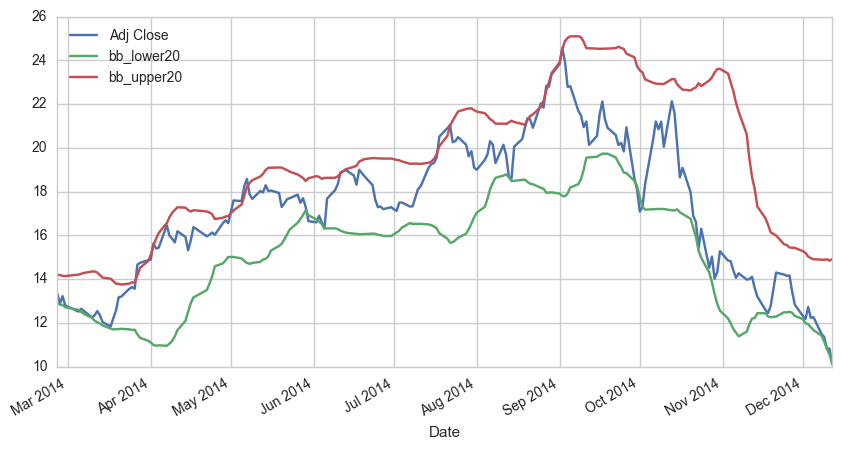

In [307]:
# Bollinger bands 
plt.figure(figsize=(10,30))
df[-200:][['Adj Close','bb_lower20', 'bb_upper20']].plot(figsize=(10,5))

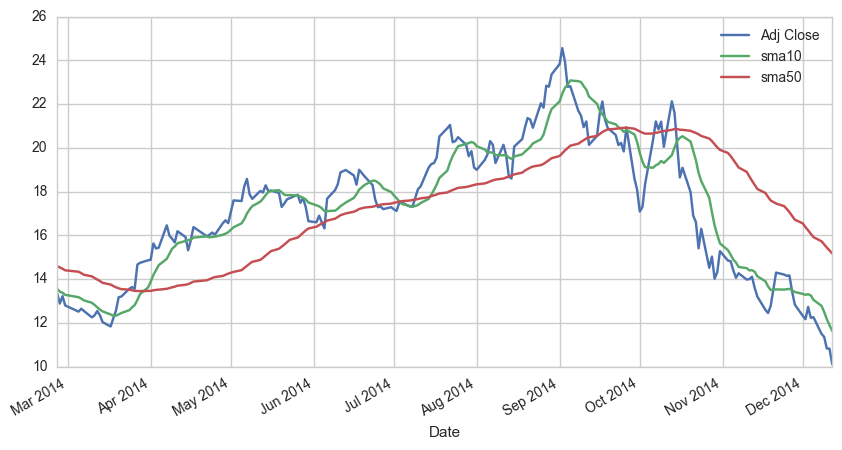

In [306]:
# Moving Averages 
df[-200:][['Adj Close','sma10', 'sma50']].plot(figsize=(10,5))

Techical analysis indicators are necessarily correlated with Adj Close. The pattern in their trend is which can be useful for prediction, as they changes in a moving average, for example, can anticipate changes in the day to day pattern